## Building the Model

We have come up with the following initial architecture: $h^1$ = 500, $h^2$ = 600, $mu$ (learning rate) = 0.01, batch size = 32, activation function = ReLU. The neural network code is provided in [neuralnetwork.py](neuralnetwork.py) with accompanying utility functions in [utils.py](utils.py). It can be run by executing the file [main.py](main.py)


The resulting number of parameters (including the biases) is 699110. It can be calculated by the applying the following formula to each layer: $(n\_inputs + 1) * neuron\_count$ and then summing it up. The $+1$ in the equation accounts for the biases.

### Initialization

The three weight initializations are performed by the following snippet:

```python
    def initialize_weights(self, i, j):
        """
        Initialize the weight matrix i x j for the layer of n entries
        :param i: number of rows of the matrix W (output of the layer)
        :param j: number of columns (input to the layer)
        :return: two-dimensional numpy array
        """
        if self.weight_init == 'zeros':
            weights = np.zeros((i, j))
        elif self.weight_init == 'normal':
            weights = np.array(np.random.normal(0, 1, (i, j)))
        elif self.weight_init == 'glorot':
            d = np.sqrt(6 / (i + j))
            weights = np.random.uniform(-d, d, (i, j))
        else:
            raise RuntimeError('Have not found initializing method for ', self.weight_init)
        return weights
```
Having trained neural networks with three different weight initializions (code snippet below), we save the results in a csv file wich is then read out and plotted. 

In [2]:
%matplotlib inline

zeros 
 [0.90136 0.88644 0.88644 0.88644 0.88644 0.88644 0.88644 0.88644 0.88644
 0.88644]
normal 
 [0.85996 0.0602  0.03438 0.0249  0.01802 0.01188 0.0062  0.0062  0.00404
 0.0027 ]
glorot 
 [0.91968 0.0909  0.07462 0.06214 0.0546  0.04844 0.04714 0.038   0.03532
 0.0314 ]


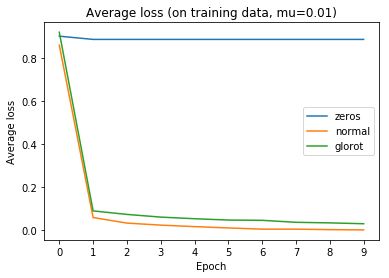

In [17]:
from matplotlib import pyplot as plt
import numpy as np

reports = [('zeros', 'report_epochs=10,hidden_dims=[500,600],mu=0.01,batch_size=32,weight_init=zeros.csv'),
           ('normal', 'report_epochs=10,hidden_dims=[500,600],mu=0.01,batch_size=32,weight_init=normal.csv'),
           ('glorot', 'report_epochs=10,hidden_dims=[500,600],mu=0.01,batch_size=32,weight_init=glorot.csv')
]

for report in reports:
    weight_init, file_name = report
    with open("reports/weight_inits/{}".format(file_name), "r") as f:
        stats = np.loadtxt(f, delimiter=",", skiprows=1)
        train = stats[:, 1]
        print(weight_init, '\n', train)
        plt.plot(train, label=weight_init)
plt.xticks(range(len(train)))
plt.legend()
plt.title('Average loss (on training data, mu=0.01)')
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.show()

**Zero initialization**. As can be seen, initializing weights with zeros results in virtually no learning as depicted by an almost flat learning curve. This can be explained by the backpropagation algorithm. 

On the forward pass all the activations (ReLUs in our case) output zeros and being multiplied by the zero weights result in zero logits. The softmax function then assigns equal probability to each prediction being 0.1 (as there are 10 classes). On the backprop the only the biases of the third layer $b^{(3)}$ have a nonzero gradient, all other parameters, including biases at other layers, are zero. 

This is because the partial derivative of the of the loss $L$ with respect to bias $b^{(k)}_i$ at layer $k$ is equal to $\frac{\partial}{\partial b^{(k)}_i} -log f(x)_y=\frac{\partial -log f(x)_y}{\partial a^{(k)}(x)_i}$. Since the preactivation at the third layer is $\frac{\partial}{\partial a^{(L+1)}(x)_c}-log f(x)_y = f(x)_c - 1_{(y=c)}$ we have nonzero derivative values at the preactivation of the output layer and therefore nonzero values for the bias at the output layer. All the other parameter values are zero because the ReLUs output zeros for the zero inputs. 


**Normal and Glorot initialization**. We observe that the learning curves for the both initialization strategies exhibit similar behavior. However, the weight values under the 'normal' initialization are higher then those under glorot which affects the learning rate. For instance, though we have seen that the normal has a better training performance when $mu$ is at $0.01$, if we change it to $0.1$ the network does not train anymore because of the numerical overflow. The same learning rate of $0.1$ for glorot actually reduces the avarage loss much quicker as can be seen in the figure below.

normal 
 [0.91358 0.88644 0.88644 0.88644 0.88644 0.88644 0.88644 0.8965  0.88644
 0.88644]
glorot 
 [8.979e-01 3.880e-02 1.904e-02 1.736e-02 9.480e-03 6.020e-03 5.660e-03
 6.220e-03 1.760e-03 7.800e-04]


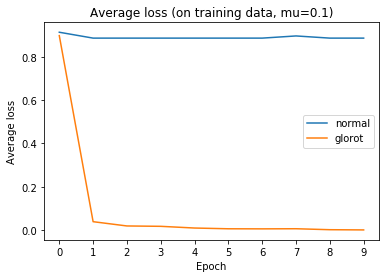

In [19]:
from matplotlib import pyplot as plt
import numpy as np

reports = [
           ('normal', 'report_epochs=10,hidden_dims=[500,600],mu=0.1,batch_size=32,weight_init=normal.csv'),
           ('glorot', 'report_epochs=10,hidden_dims=[500,600],mu=0.1,batch_size=32,weight_init=glorot.csv')
]

for report in reports:
    weight_init, file_name = report
    with open("reports/weight_inits/{}".format(file_name), "r") as f:
        stats = np.loadtxt(f, delimiter=",", skiprows=1)
        train = stats[:, 1]
        print(weight_init, '\n', train)
        plt.plot(train, label=weight_init)
plt.xticks(range(len(train)))
plt.legend()
plt.title('Average loss (on training data, mu=0.1)')
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.show()

### Hyperparameter Search

We use random search to find the best hyperparameters. For that we first define a range of combinations of valid hyperparameters as in the following snippet. Please note, that we use **log scale** to define a range of learning rate values

In [15]:
# using log-scale for the learning rate: http://cs231n.github.io/neural-networks-3/#hyper
mus = [10 ** np.random.uniform(-6, 1) for _ in range(0, 5)] 
neurons = [[500, 600], [500, 500], [600, 700], [700, 500]]
combinations = [(mu, neuron) for mu in mus for neuron in neurons]
print('possible combinations:\n', combinations)

possible combinations:
 [(4.614313552623348e-05, [500, 600]), (4.614313552623348e-05, [500, 500]), (4.614313552623348e-05, [600, 700]), (4.614313552623348e-05, [700, 500]), (0.1468423686421048, [500, 600]), (0.1468423686421048, [500, 500]), (0.1468423686421048, [600, 700]), (0.1468423686421048, [700, 500]), (0.3112553202446868, [500, 600]), (0.3112553202446868, [500, 500]), (0.3112553202446868, [600, 700]), (0.3112553202446868, [700, 500]), (4.311580209552355e-06, [500, 600]), (4.311580209552355e-06, [500, 500]), (4.311580209552355e-06, [600, 700]), (4.311580209552355e-06, [700, 500]), (0.013249755451138266, [500, 600]), (0.013249755451138266, [500, 500]), (0.013249755451138266, [600, 700]), (0.013249755451138266, [700, 500])]


Having obtained a range of parameters to test we have perform a **random search** over possible combinations a pick 10 samples with which to train the neural network. The script (hyperparameter_search.py)[hyperparameter_search.py] performs training and saves their performance data in a report. Thereafter we use gathered reports (moved to the folder "report/hyperparams") to plot the results of the ten experiments and determined the model with the best performance.

Hyperparameters                                   |Accuracy  
------------------------------------------------------------
hidden_dims=[600,700],mu=4.311580209552355e-06    |17.20     
hidden_dims=[500,600],mu=0.3112553202446868       |97.63     
hidden_dims=[600,700],mu=4.614313552623348e-05    |70.23     
hidden_dims=[700,500],mu=0.1468423686421048       |98.28     
hidden_dims=[700,500],mu=0.013249755451138266     |97.11     
hidden_dims=[600,700],mu=0.013249755451138266     |97.11     
hidden_dims=[700,500],mu=4.311580209552355e-06    |22.76     
hidden_dims=[600,700],mu=0.3112553202446868       |98.21     
hidden_dims=[700,500],mu=0.3112553202446868       |98.38     
hidden_dims=[500,500],mu=4.614313552623348e-05    |64.49     

Best model with params  hidden_dims=[700,500],mu=0.3112553202446868  has accuracy of  98.38


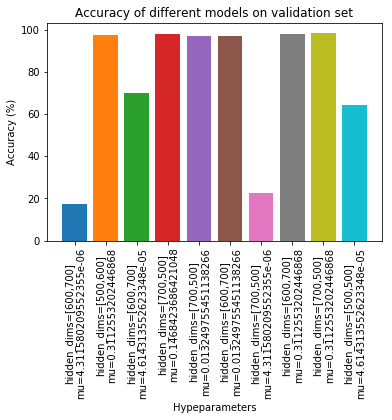

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import os


reports = [f.replace('.csv', '') for f in os.listdir("reports/hyperparams")]

best_model = None
y_pos = np.arange(len(reports))
template = "{0:50}|{1:10}"
print(template.format('Hyperparameters', 'Accuracy'))
print(''.join(['-' for _ in range(60)]))
for idx, hp in enumerate(reports):
    with open("reports/hyperparams/{}.csv".format(hp), "r") as f:
        stats = np.loadtxt(f, delimiter=",", skiprows=1)
        accuracy = (1 - stats[-1, 3]) * 100
        print(template.format(hp, "%.2f" % accuracy))
        if best_model is None or best_model[1] < accuracy:
            best_model = (hp, accuracy)
        plt.bar(idx, accuracy, label=hp)

print('\nBest model with params ', best_model[0], ' has accuracy of ', best_model[1])
plt.xticks(y_pos, [r.replace(',m','\nm') for r in reports], rotation=90)
plt.title('Accuracy of different models on validation set')
plt.xlabel('Hypeparameters')
plt.ylabel('Accuracy (%)')
plt.show()

### Validate Gradients using Finite Difference


To validate the gradients, we run a test case `test_validate_gradient` from [tests.py](tests.py). It loads the trained best performing model from the checkpoints and performs a gradient check on the second layer using epsilon values $\frac{1}{N}$from the whole set of $N=\{k10^i : i \in \{0, . . . , 5\}, k \in \{1, 5\}\}$. 

We adhere to the advices provided in the write up __[CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/neural-networks-3/#gradient-checks)__:
- Use of relative error for the comparizon between the analytical (estimated) and the numerical (finite difference) gradients $\frac{|f'_a - f'_n|}{max(|f'_a|,|f'_n|)}$
- We use a threshold value of `1e-4` as a tolerance for the relative error. The reason for this is that our neural network has softmax
- We account for the kinks -- nondifferentiable parts in the objective function, ie ReLUs -- by keeping track of the identities of the winners. This is explained in the article in more detail, but we monitor whether __any__ of the ReLUs output different candidates when doing a forward pass. for instance for $f(x+h)$ in one of the ReLUs $x$ was a winner, whereas for $f(x-h)$ for the same ReLU it was $0$. That signifies that due to the perturbation of the weight we have crossed a non-differentiable kink of the activation function and therefore the gradient check is not reliable
- Gradient check is performed on the trained model


The method that is being called by the test is `NN._validate_gradient()`, and it is depicted below. There are several points that are worth noting. 

```python 
def _validate_gradient(self, x, y, model_parameters, backprop_gradient):
    """
    Validate if the gradient calculated by backpropagation algorithm is similar
    to the empirical gradient calculated with finite step epsilon
    :param x: array of features
    :param y: array of labels
    :param backprop_gradient: gradient calculated by backpropagation algorithm
    :raises: exception if the calculated algorithm is too different from empirical
    """
    # calculate finite gradient
    print('\n\n===Validating gradient for epsilon=', self.epsilon, '===')
    for pidx, pname in enumerate(model_parameters):
        # Get the actual parameter value by it's name, e.g. w1, w2 etc
        parameter = self.__getattribute__(pname)

        # Iterate over each element of the parameter matrix,
        # method returns indexes (i, j) of each element e.g. (0,0), (0,1), ...
        it = np.nditer(parameter, flags=['multi_index'], op_flags=['readwrite'])

        # verify only 10 parameters
        verified = 0
        while not it.finished and verified < 10:

            verified += 1

            # ix = (i, j)
            ix = it.multi_index

            # Save the original value so we can reset it later
            original_value = parameter[ix]

            # Estimate the gradient using (f(x+h) - f(x-h))/2h
            # calculate the empirical error for x+h
            parameter[ix] = original_value + self.epsilon
            self.forward(x)
            x_p_h_relu_winners = self._calc_max_winners()

            grad_plus = self.loss(y)

            # calculate the empirical error for x-h
            parameter[ix] = original_value - self.epsilon
            self.forward(x)
            x_m_h_relu_winners = self._calc_max_winners()
            grad_minus = self.loss(y)

            # Reset parameter to original value
            parameter[ix] = original_value

            # verify gradient
            estimated_gradient = (grad_plus - grad_minus) / (2 * self.epsilon)
            calculated_gradient = backprop_gradient[pidx][ix]
            diff = np.abs(calculated_gradient - estimated_gradient)
            # https://www.youtube.com/watch?v=P6EtCVrvYPU -- general
            # http://ufldl.stanford.edu/wiki/index.php/Gradient_checking_and_advanced_optimization
            # http://cs231n.github.io/neural-networks-3/#gradcheck -- kinks, relative error
            max_val = np.max([np.abs(calculated_gradient), np.abs(estimated_gradient)])
            rel_error = diff / max_val if max_val != 0 else 0
            threshold = 1e-4
            diff_winners = (np.equal(x_p_h_relu_winners[0], x_m_h_relu_winners[0])).any() \
                           or (x_p_h_relu_winners[1] != x_m_h_relu_winners[1]).any()
            kinks_crossed = '(kinks crossed)'.format(diff_winners) if rel_error > threshold else ''
            print(pname, ' gradient diff: ', diff, '', kinks_crossed)
            if rel_error > threshold and not diff_winners:
                print("------------- error ---------------")
                print(pname, ' relative error: ', rel_error)
                print(pname + " estimated gradient: ", estimated_gradient)
                print(pname + " calculated gradient: ", calculated_gradient)
                raise RuntimeError("gradient error {} is above threshold {} (epsilon {})".
                                   format(rel_error, threshold, self.epsilon))
            it.iternext()
```